<a href="https://colab.research.google.com/github/mohmaed7777/Feedback-Prize---Predicting-Effective-Arguments/blob/main/Feedback_prize_EDA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Kaggle :
! pip install Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c feedback-prize-effectiveness

 61% 5.00M/8.13M [00:00<00:00, 34.9MB/s]
100% 8.13M/8.13M [00:00<00:00, 53.4MB/s]


In [ ]:
! unzip feedback-prize-effectiveness.zip

# **Summary of the competition task:**
 * **The goal of this competition is to classify argumentative elements in student writing as "effective," "adequate," or "ineffective."**

*   **You will create a model trained on data that is representative of the 6th-12th grade population in the United States in order to minimize bias.**

*  **Models derived from this competition will help pave the way for students to receive enhanced feedback on their argumentative writing.**

# **Data Context:=**

*  **The dataset presented here contains argumentative essays written by U.S students in grades 6-12. These essays were annotated by expert raters for discourse elements commonly found in argumentative writing:**

* **Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis**

* **Position - an opinion or conclusion on the main question.**

* **Claim - a claim that supports the position.**

* **Counterclaim - a claim that refutes another claim or gives an opposing reason to the position.**

* **Rebuttal - a claim that refutes a counterclaim.**
* **Evidence - ideas or examples that support claims, counterclaims, or rebuttals.**
* **Concluding Statement - a concluding statement that restates the claims**

# **Your task is to predict the quality rating of each discourse element. Human readers rated each rhetorical or argumentative element, in order of increasing quality, as one of:**

**Ineffective**

**Adequate**

**Effective**

 


# **Importing Libraries:=**

In [7]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score,recall_score

# **NLP Libraries:=**

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

%matplotlib inline

In [9]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample_s = pd.read_csv('/content/sample_submission.csv')
print(f'Train_shape: {train.shape}, Test_shape: {test.shape}, Sample_shape:{sample_s.shape}')

display(train.sample(2))
display(test.sample(2))
display(sample_s.sample(2))

Train_shape: (36765, 5), Test_shape: (10, 4), Sample_shape:(10, 4)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
4510,745e637a8c63,507CBD8E9670,Venus is often reffered to as Earth's twin bec...,Evidence,Ineffective
23192,4ae4054c834e,754CED955EFD,because they have to persude the electorates t...,Claim,Adequate


,discourse_id,essay_id,discourse_text,discourse_type
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim
9,bcfae2c9a244,D72CB1C11673,You can learn from others experiences by seeki...,Concluding Statement


,discourse_id,Ineffective,Adequate,Effective
5,2e214524dbe3,0.20,0.60,0.40
9,bcfae2c9a244,0.01,0.24,0.47


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [11]:
train.isnull().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

In [12]:
train.describe(include='object')

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [13]:
train['discourse_type'].value_counts()

Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

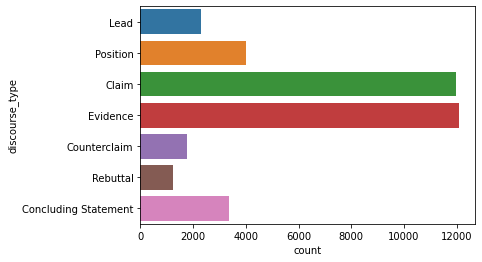

In [14]:
sns.countplot(y=train['discourse_type'], data=train)

**Ploting the testset:=**

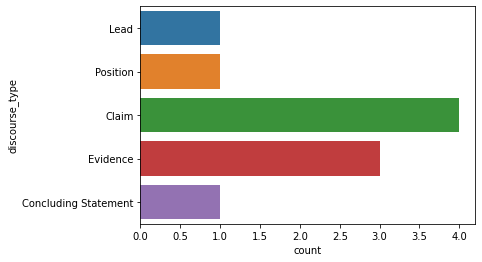

In [15]:
sns.countplot(y=test['discourse_type'], data=test)

In [16]:
train['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

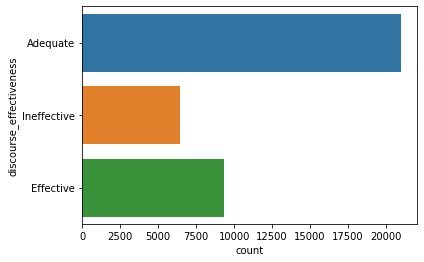

In [17]:
sns.countplot(y=train['discourse_effectiveness'], data=train)

# **identify the imblanced data in the discourse type:=**

In [18]:
def count_target(target_list): 
  target_dict = {}
  for x in target_list:
    count = len(train['discourse_type'] == x)
    dict_t = dict({x:count})
    target_dict.update(dict_t)

  return target_dict

target_list = ['Lead', 'Position', 'Claim', 'Evidence', 'Counterclaim',
       'Rebuttal', 'Concluding Statement']
count_target(target_list)    

{'Claim': 36765,
 'Concluding Statement': 36765,
 'Counterclaim': 36765,
 'Evidence': 36765,
 'Lead': 36765,
 'Position': 36765,
 'Rebuttal': 36765}

In [19]:
def count_target(target_list): 
  target_dict = {}
  for x in target_list:
    count = len(test['discourse_type'] == x)
    dict_t = dict({x:count})
    target_dict.update(dict_t)

  return target_dict

target_list = ['Lead', 'Position', 'Claim', 'Evidence', 'Counterclaim',
       'Rebuttal', 'Concluding Statement']
count_target(target_list)    

{'Claim': 10,
 'Concluding Statement': 10,
 'Counterclaim': 10,
 'Evidence': 10,
 'Lead': 10,
 'Position': 10,
 'Rebuttal': 10}

# **KFold:**

In [20]:
# add extra one column: 
train['kfold']=-2
# Distributing the data: 
kfold = KFold(n_splits=20, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kfold.split(X=train)):
  train.loc[valid_indicies, 'kfold'] = fold

print(train.kfold.value_counts())

# output of train folds data: 
train.to_csv('trainfold_20.csv', index=False)

1     1839
0     1839
4     1839
2     1839
3     1839
5     1838
10    1838
18    1838
8     1838
9     1838
15    1838
12    1838
17    1838
16    1838
13    1838
19    1838
11    1838
7     1838
14    1838
6     1838
Name: kfold, dtype: int64


In [21]:
train = pd.read_csv('/content/trainfold_20.csv')
train.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,5
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,16
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,14
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,7
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0


In [22]:
# preprocessing with NLTK:
# clean the discourse_text attribute and generate clean one:
def cleanup_text(text):
  words = re.sub(pattern='[^a-zA-Z]', repl=' ', string=text)
  words = words.lower()
  return words

cleanup_text('Syew443@@@,[amazing]')  

'syew        amazing '

In [23]:
text_preprocessed = train['discourse_text'].apply(cleanup_text)
text_preprocessed
train['text_preprocessed'] = text_preprocessed
train.sample(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold,text_preprocessed
14188,7cf734dca463,FC9BC150809F,Before cars weren't invented people walked. Pe...,Evidence,Ineffective,5,before cars weren t invented people walked pe...
4651,abb14cb300c2,53DE53537B56,Also students that know their topic are going ...,Claim,Effective,17,also students that know their topic are going ...


In [24]:
test_preprocessed = test['discourse_text'].apply(cleanup_text)
test_preprocessed
test['text_preprocessed'] =  test_preprocessed
test.head()

,discourse_id,essay_id,discourse_text,discourse_type,text_preprocessed
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead,making choices in life can be very difficult ...
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position,seeking multiple opinions can help a person ma...
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim,it can decrease stress levels
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim,a great chance to learn something new
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim,can be very helpful and beneficial


# **Map the target data:=**

In [25]:
effectiveness_map = {'Ineffetive': 0, 'Adequate':1, 'Effective':2}
train['target'] = train['discourse_effectiveness'].map(effectiveness_map)
train.sample(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold,text_preprocessed,target
34511,634f288f78e0,5C69070E1E48,because you can stay at home,Claim,Adequate,11,because you can stay at home,1.0
15997,c1e2c191b7dc,15F80BF4B3C9,It has been brought to my attention as to whic...,Lead,Adequate,18,it has been brought to my attention as to whic...,1.0


In [26]:
train.tail()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,kfold,text_preprocessed,target
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate,4,for many people they don t like only asking on...,1.0
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate,11,also people have different views and opinions ...,1.0
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate,13,advice is something that can impact a persons ...,1.0
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective,4,someone can use everything that many people sa...,NaN
36764,c8a973681feb,FFA381E58FC6,In conclusion asking for an opinion can be ben...,Concluding Statement,Ineffective,8,in conclusion asking for an opinion can be ben...,NaN


# **Preprocessing - Apply one hot encoding in (discourse type), TFIDF vectorize in (Discourse text and cleaning text)**

In [27]:
tf = TfidfVectorizer(ngram_range=(1,2),norm='l2', smooth_idf=True)
train_discourse_tfidf = tf.fit_transform(train["discourse_text"])
test_discourse_tfidf = tf.transform(test["discourse_text"])

In [28]:
tf = TfidfVectorizer(ngram_range=(1,2),norm='l2', smooth_idf=True) # Load tf another time because it will learn the new vocabulary for 'text'
train_text_tfidf = tf.fit_transform(train["text_preprocessed"])
test_text_tfidf = tf.transform(test["text_preprocessed"])

In [29]:
#discourse_type
ohe = OneHotEncoder()
train_type_ohe =  sparse.csr_matrix(ohe.fit_transform(train["discourse_type"].values.reshape(-1,1)))
test_type_ohe =  sparse.csr_matrix(ohe.transform(test["discourse_type"].values.reshape(-1,1)))

In [30]:
#Stack each vector representations 
train_tfidf = sparse.hstack((train_type_ohe,train_discourse_tfidf,train_text_tfidf))
test_tfidf = sparse.hstack((test_type_ohe,test_discourse_tfidf,test_text_tfidf))

In [31]:
train_tfidf

<36765x674046 sparse matrix of type '<class 'numpy.float64'>'
	with 5298789 stored elements in COOrdinate format>

# **Trying Models:=**

In [32]:
train['target'].dtypes

dtype('float64')

In [33]:
train.isnull().sum()

discourse_id                  0
essay_id                      0
discourse_text                0
discourse_type                0
discourse_effectiveness       0
kfold                         0
text_preprocessed             0
target                     6462
dtype: int64

In [34]:
train['target'].describe()

count    30303.000000
mean         1.307758
std          0.461574
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: target, dtype: float64

In [35]:
train.fillna(0, inplace=True)

In [ ]:
#train['target'] = train['target'].apply(np.int64)

In [36]:
# LogisticRegression:=
lgr_model = LogisticRegression(max_iter=1000,penalty="l2",C=1.0131816333513533)
lgr_model.fit(train_tfidf, train['target'].values)


LogisticRegression(C=1.0131816333513533, max_iter=1000)

In [37]:
lgr_prediction = lgr_model.predict_proba(test_tfidf)
lgr_prediction

array([[0.01053939, 0.1721507 , 0.81730991],
       [0.01321092, 0.70451465, 0.28227443],
       [0.0887018 , 0.43360362, 0.47769458],
       [0.08578091, 0.57931922, 0.33489987],
       [0.04182222, 0.56902597, 0.38915182],
       [0.03150541, 0.1301414 , 0.83835319],
       [0.01898223, 0.30364322, 0.67737454],
       [0.04456049, 0.54947231, 0.4059672 ],
       [0.21877018, 0.34065269, 0.44057713],
       [0.01741011, 0.1836937 , 0.79889619]])

In [39]:
sample_s.loc[:,"Ineffective"] = lgr_prediction[:,0]
sample_s.loc[:,"Adequate"] = lgr_prediction[:,1]
sample_s.loc[:,"Effective"] = lgr_prediction[:,2]
sample_s.to_csv('submission.csv',index=False)

In [40]:
sample_s.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.010539,0.172151,0.817310
1,5a88900e7dc1,0.013211,0.704515,0.282274
2,9790d835736b,0.088702,0.433604,0.477695
3,75ce6d68b67b,0.085781,0.579319,0.334900
4,93578d946723,0.041822,0.569026,0.389152


# **Boosting Method:=**